# 전이 학습 및 미세 조정

**저자:** [fchollet](https://twitter.com/fchollet)  
**생성일:** 2020/04/15  
**최종편집일:** 2023/06/25  
**설명:** Keras의 전이 학습 및 미세 조정에 대한 완벽한 가이드입니다.

In [1]:
# 이 노트북은 Keras 3이 설치되어 있다는 가정 하에 진행됩니다.
#
# !pip install keras --upgrade --quiet

In [2]:
import numpy as np
import os

os.environ["KERAS_BACKEND"] = "jax"

In [3]:
from keras import backend
print(backend.backend())

jax


In [4]:
import keras
keras.__version__

'3.4.1'

## 셋업

In [5]:
import numpy as np
import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

## 소개

**전이 학습**(Transfer learning)은 한 문제에서 학습된 특성을 새로운, 유사한 문제에 활용하는 것을 말합니다.
예를 들어, 라쿤을 식별하는 모델에서 학습된 특성은 너구리(tanuki)를 식별하려는 모델을 시작하는 데 유용할 수 있습니다.

전이 학습은 보통 데이터셋이 부족하여, 처음부터 완전한 모델을 트레이닝하기 어려운 작업에 사용됩니다.

딥러닝에서 전이 학습의 가장 일반적인 형태는 다음과 같은 워크플로입니다:

1.  이전에 트레이닝된 모델의 레이어를 가져옵니다.
2.  그 레이어들을 동결(freeze)하여, 이후 트레이닝에서 해당 정보가 파괴되지 않도록 합니다.
3.  동결된 레이어 위에 새로운 트레이닝 가능한 레이어를 추가합니다.
    이 레이어들은 기존의 특징을 새로운 데이터셋에 대한 예측으로 변환하는 것을 학습합니다.
4.  새로운 레이어들을 데이터셋에 맞게 트레이닝합니다.

마지막으로 선택적으로 할 수 있는 단계는 **미세 조정**(fine-tuning)입니다.
이는 위에서 얻은 전체 모델(또는 그 일부)을 동결 해제(unfreeze)하고,
매우 낮은 학습률로 새로운 데이터에 대해 다시 트레이닝하는 것을 말합니다.
이렇게 하면 사전 트레이닝된 특징을 새로운 데이터에 맞게 점진적으로 적응시켜 유의미한 개선을 이룰 수 있습니다.

먼저, 대부분의 전이 학습 및 미세 조정 워크플로를 기반으로 하는 Keras의 `trainable` API를 자세히 살펴보겠습니다.

그런 다음, ImageNet 데이터셋에서 사전 트레이닝된 모델을 가져와,
Kaggle의 "cats vs dogs" 분류 데이터셋에서 다시 트레이닝하는 일반적인 워크플로를 시연하겠습니다.

이 내용은 [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python) 및
2016년 블로그 게시물 ["아주 적은 데이터로 강력한 이미지 분류 모델 만들기"](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)에서 각색되었습니다.

## 레이어 동결: `trainable` 속성 이해하기

레이어 및 모델에는 세 가지 가중치 속성이 있습니다:

*   `weights`는 레이어의 모든 가중치 변수를 포함한 리스트입니다.
*   `trainable_weights`는 트레이닝 중 손실을 최소화하기 위해,
    (경사 하강법을 통해) 업데이트될 가중치들의 리스트입니다.
*   `non_trainable_weights`는 트레이닝되지 않도록 설정된 가중치들의 리스트입니다.
    일반적으로 이는 모델이 순방향 패스를 수행할 때 업데이트됩니다.

**예시: `Dense` 레이어는 2개의 트레이닝 가능한 가중치(kernel 및 bias)를 가집니다.**

In [6]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # 가중치 생성

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 2
non_trainable_weights: 0


일반적으로, 모든 가중치는 트레이닝 가능한 가중치입니다.
유일하게 빌트인 레이어 중 트레이닝 불가능한 가중치를 가진 레이어는 `BatchNormalization` 레이어입니다.
이 레이어는 트레이닝 중 입력의 평균과 분산을 추적하기 위해, 트레이닝 불가능한 가중치를 사용합니다.
커스텀 레이어에서 트레이닝 불가능한 가중치를 사용하는 방법을 배우려면,
[새로운 레이어를 처음부터 작성하는 가이드](https://codecompose7.github.io/keras-doc-kr.github.io/guides/making_new_layers_and_models_via_subclassing/)를 참고하세요.

**예시: `BatchNormalization` 레이어는 2개의 트레이닝 가능한 가중치와 2개의 트레이닝 불가능한 가중치를 가집니다.**

In [7]:
layer = keras.layers.BatchNormalization()
layer.build((None, 4))  # 가중치 생성

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 4
trainable_weights: 2
non_trainable_weights: 2


레이어와 모델에는 `trainable`이라는 boolean 속성이 있습니다. 이 값은 변경할 수 있습니다.
`layer.trainable`을 `False`로 설정하면,
해당 레이어의 모든 가중치가 트레이닝 가능한 상태에서 트레이닝 불가능한 상태로 이동합니다.
이를 "레이어 동결(freezing)"이라고 하며, 동결된 레이어의 상태는 트레이닝 중에 업데이트되지 않습니다.
(`fit()`을 사용한 트레이닝이든,
`trainable_weights`에 의존하여 그래디언트 업데이트를 적용하는 커스텀 루프에서든 마찬가지입니다)

**예시: `trainable`을 `False`로 설정**

In [8]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # 가중치 생성
layer.trainable = False  # 레이어 동결

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))

weights: 2
trainable_weights: 0
non_trainable_weights: 2


트레이닝 가능한 가중치가 트레이닝 불가능한 가중치로 바뀌면, 해당 가중치의 값은 더 이상 트레이닝 중에 업데이트되지 않습니다.

In [9]:
# 두 개의 레이어로 모델을 만듭니다.
layer1 = keras.layers.Dense(3, activation="relu")
layer2 = keras.layers.Dense(3, activation="sigmoid")
model = keras.Sequential([keras.Input(shape=(3,)), layer1, layer2])

# 첫 번째 레이어를 동결합니다.
layer1.trainable = False

# 나중에 참조할 수 있도록 layer1의 가중치를 복사해둡니다.
initial_layer1_weights_values = layer1.get_weights()

# 모델을 트레이닝합니다.
model.compile(optimizer="adam", loss="mse")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

# 트레이닝 중에 layer1의 가중치가 변경되지 않았는지 확인합니다.
final_layer1_weights_values = layer1.get_weights()
np.testing.assert_allclose(
    initial_layer1_weights_values[0], final_layer1_weights_values[0]
)
np.testing.assert_allclose(
    initial_layer1_weights_values[1], final_layer1_weights_values[1]
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.0713


`layer.trainable` 속성과 `layer.__call__()`의 인자 `training`을 혼동하지 마세요.
`training` 인자는 레이어가 추론 모드 또는 트레이닝 모드에서 순방향 패스를 실행할지 여부를 제어합니다.
자세한 내용은 [Keras FAQ](https://codecompose7.github.io/keras-doc-kr.github.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute)를 참고하세요.

## `trainable` 속성의 재귀적 설정

모델이나 서브레이어를 가진 레이어에서 `trainable = False`로 설정하면,
모든 하위 레이어도 트레이닝 불가능한 상태가 됩니다.

**예시:**

In [10]:
inner_model = keras.Sequential(
    [
        keras.Input(shape=(3,)),
        keras.layers.Dense(3, activation="relu"),
        keras.layers.Dense(3, activation="relu"),
    ]
)

model = keras.Sequential(
    [
        keras.Input(shape=(3,)),
        inner_model,
        keras.layers.Dense(3, activation="sigmoid"),
    ]
)

model.trainable = False  # 바깥 모델을 동결합니다.

assert inner_model.trainable == False  # 이제 `model`의 모든 레이어가 동결되었습니다.
assert inner_model.layers[0].trainable == False  # `trainable`이 재귀적으로 전파됩니다.

## 일반적인 전이 학습 워크플로

이제 Keras에서 전이 학습 워크플로를 구현하는 일반적인 방법에 대해 알아보겠습니다:

1.  베이스 모델을 인스턴스화하고 사전 트레이닝된 가중치를 로드합니다.
2.  `trainable = False`로 설정하여, 베이스 모델의 모든 레이어를 동결합니다.
3.  베이스 모델의 한 개 이상의 레이어 출력 위에 새로운 모델을 만듭니다.
4.  새로운 데이터셋으로 새 모델을 트레이닝합니다.

또한, 더 가벼운 워크플로는 다음과 같이 할 수도 있습니다:

1.  베이스 모델을 인스턴스화하고 사전 트레이닝된 가중치를 로드합니다.
2.  새로운 데이터셋을 통해 베이스 모델을 실행하고, 베이스 모델의 한 개 이상의 레이어 출력을 기록합니다.
    이를 **특성 추출**이라고 합니다.
3.  그 출력을 새로운, 더 작은 모델의 입력 데이터로 사용합니다.

이 두 번째 워크플로의 주요 장점은 데이터를 사용할 때 베이스 모델을 한 번만 실행하면 되므로,
에포크마다 베이스 모델을 실행하지 않아도 되기 때문에, 훨씬 빠르고 비용이 저렴하다는 점입니다.

그러나 두 번째 워크플로의 단점은, 트레이닝 중에 새 모델의 입력 데이터를 동적으로 수정할 수 없다는 점입니다.
예를 들어, 데이터 보강을 할 때는 이것이 필요합니다.
전이 학습은 일반적으로 새로운 데이터셋이 부족하여,
처음부터 대규모 모델을 트레이닝할 수 없을 때 사용되며,
이러한 상황에서 데이터 보강은 매우 중요합니다.
따라서, 아래에서는 첫 번째 워크플로에 초점을 맞추겠습니다.

다음은 Keras에서 첫 번째 워크플로가 어떻게 보이는지입니다:

먼저, 사전 트레이닝된 가중치로 기본 모델을 인스턴스화합니다.

```python
base_model = keras.applications.Xception(
    weights='imagenet',  # ImageNet에서 사전 트레이닝된 가중치 로드.
    input_shape=(150, 150, 3),
    include_top=False)  # ImageNet 분류기를 상단에 포함하지 않음.
```

그런 다음, 베이스 모델을 동결합니다.

```python
base_model.trainable = False
```

상단에 새로운 모델을 생성합니다.

```python
inputs = keras.Input(shape=(150, 150, 3))
# 여기서 베이스 모델이 추론 모드로 실행되도록, `training=False`를 전달합니다.
# 이는 미세 조정을 할 때 매우 중요합니다. 이 부분은 이후에 다룰 예정입니다.
x = base_model(inputs, training=False)
# `base_model.output_shape[1:]` 형태의 특성을 벡터로 변환합니다.
x = keras.layers.GlobalAveragePooling2D()(x)
# 단일 유닛을 가진 Dense 분류기 (이진 분류)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
```

새로운 데이터로 모델을 트레이닝합니다.

```python
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
model.fit(new_dataset, epochs=20, callbacks=..., validation_data=...)
```

## 미세 조정

모델이 새로운 데이터에 대해 수렴한 후, 베이스 모델의 전체 또는 일부를 동결 해제하고,
매우 낮은 학습률로 전체 모델을 엔드 투 엔드로 다시 트레이닝할 수 있습니다.

이 단계는 선택적인 마지막 단계로, 점진적인 개선을 얻을 수 있습니다.
하지만, 과적합이 빠르게 발생할 수도 있다는 점을 유의해야 합니다.

모델의 동결된 레이어가 수렴된 *후에만* 이 단계를 수행하는 것이 중요합니다.
무작위로 초기화된 트레이닝 가능한 레이어와 사전 트레이닝된 특성을 보유한 트레이닝 가능한 레이어를 섞으면,
무작위로 초기화된 레이어가 트레이닝 중에 매우 큰 그래디언트 업데이트를 유발해,
사전 트레이닝된 특성을 파괴할 수 있습니다.

또한, 이 단계에서 매우 낮은 학습률을 사용하는 것이 중요합니다.
이는 첫 번째 트레이닝보다 훨씬 큰 모델을 일반적으로 매우 작은 데이터셋으로 트레이닝하기 때문입니다.
큰 가중치 업데이트를 적용하면 매우 빠르게 과적합될 위험이 있습니다.
여기서는 사전 트레이닝된 가중치를 점진적으로 재적응시키고자 하는 것입니다.

다음은 전체 베이스 모델의 미세 조정을 구현하는 방법입니다:

```python
# 베이스 모델의 동결 해제
base_model.trainable = True

# `trainable` 속성을 변경한 후에는 모델을 다시 컴파일하는 것이 중요합니다.
# 이렇게 해야 변경 사항이 반영됩니다.
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # 매우 낮은 학습률
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

# 엔드 투 엔드로 트레이닝. 과적합이 발생하기 전에 주의해서 멈추세요!
model.fit(new_dataset, epochs=10, callbacks=..., validation_data=...)
```

**`compile()`과 `trainable`에 대한 중요한 참고 사항**

모델에서 `compile()`을 호출하면, 그 모델의 동작이 "동결(freeze)"됩니다.
즉, 모델이 컴파일될 때의 `trainable` 속성 값이 이후,
다시 `compile`이 호출되기 전까지 유지됩니다.
따라서, 어떤 `trainable` 값을 변경한 경우,
변경 사항이 반영되도록 모델에서 `compile()`을 다시 호출해야 합니다.

**`BatchNormalization` 레이어에 대한 중요한 참고 사항**

많은 이미지 모델에는 `BatchNormalization` 레이어가 포함되어 있습니다. 이 레이어는 모든 면에서 특별한 경우에 해당합니다. 다음 몇 가지 사항을 염두에 두어야 합니다.

*   `BatchNormalization`은 트레이닝 중에 업데이트되는 2개의 트레이닝 불가능한 가중치를 포함합니다.
    이는 입력의 평균과 분산을 추적하는 변수들입니다.
*   `bn_layer.trainable = False`로 설정하면, `BatchNormalization` 레이어는 추론 모드에서 실행되며,
    평균과 분산 통계를 업데이트하지 않습니다.
    이는 일반적인 다른 레이어에서는 해당되지 않습니다.
    [가중치의 트레이닝 가능 여부와 추론/트레이닝 모드는 서로 독립적인 개념](https://codecompose7.github.io/keras-doc-kr.github.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute)이지만,
    `BatchNormalization` 레이어에서는 이 둘이 연결되어 있습니다.
*   미세 조정을 위해 `BatchNormalization` 레이어가 포함된 모델을 동결 해제하는 경우,
    베이스 모델을 호출할 때 `training=False`를 전달하여,
    `BatchNormalization` 레이어가 추론 모드에서 유지되도록 해야 합니다.
    그렇지 않으면, 트레이닝 불가능한 가중치에 적용된 업데이트가 모델이 학습한 내용을 갑자기 파괴할 수 있습니다.

이 가이드를 끝까지 읽으면, 이 패턴이 실제로 어떻게 작동하는지 확인할 수 있습니다.

## 엔드 투 엔드 예시: cats vs dogs 데이터셋에 대해 이미지 분류 모델 미세 조정

이 개념들을 더 확실히 하기 위해, 구체적인 엔드 투 엔드 전이 학습 및 미세 조정 예제를 살펴보겠습니다.
우리는 ImageNet에서 사전 트레이닝된 Xception 모델을 로드한 후,
Kaggle의 "고양이 vs 개" 분류 데이터셋에서 사용할 것입니다.

### 데이터 가져오기

먼저, TFDS를 사용하여 고양이 vs 개 데이터셋을 가져오겠습니다.
여러분이 직접 데이터셋을 가지고 있다면,
[`keras.utils.image_dataset_from_directory`](https://codecompose7.github.io/keras-doc-kr.github.io/api/data_loading/image#imagedatasetfromdirectory-function) 유틸리티를 사용하여,
디스크에 클래스별 폴더로 나누어진 이미지 집합에서 유사한 라벨링된 데이터셋 객체를 생성할 수 있습니다.

전이 학습은 매우 작은 데이터셋을 다룰 때 가장 유용합니다.
데이터셋을 작게 유지하기 위해 원래의 트레이닝 데이터(25,000개의 이미지) 중 40%를 트레이닝에 사용하고,
10%는 검증, 10%는 테스트에 사용할 것입니다.

In [12]:
# tfds.disable_progress_bar()
tfds.enable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # 10%를 검증, 10%를 테스트로 예약
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # 라벨 포함
)

print(f"트레이닝 샘플 수: {train_ds.cardinality()}")
print(f"검증 샘플 수: {validation_ds.cardinality()}")
print(f"테스트 샘플 수: {test_ds.cardinality()}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incompleteYPXN0H/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
트레이닝 샘플 수: 9305
검증 샘플 수: 2326
테스트 샘플 수: 2326


다음은 트레이닝 데이터셋에 있는 첫 9개의 이미지입니다. 보시다시피, 모두 크기가 다릅니다.

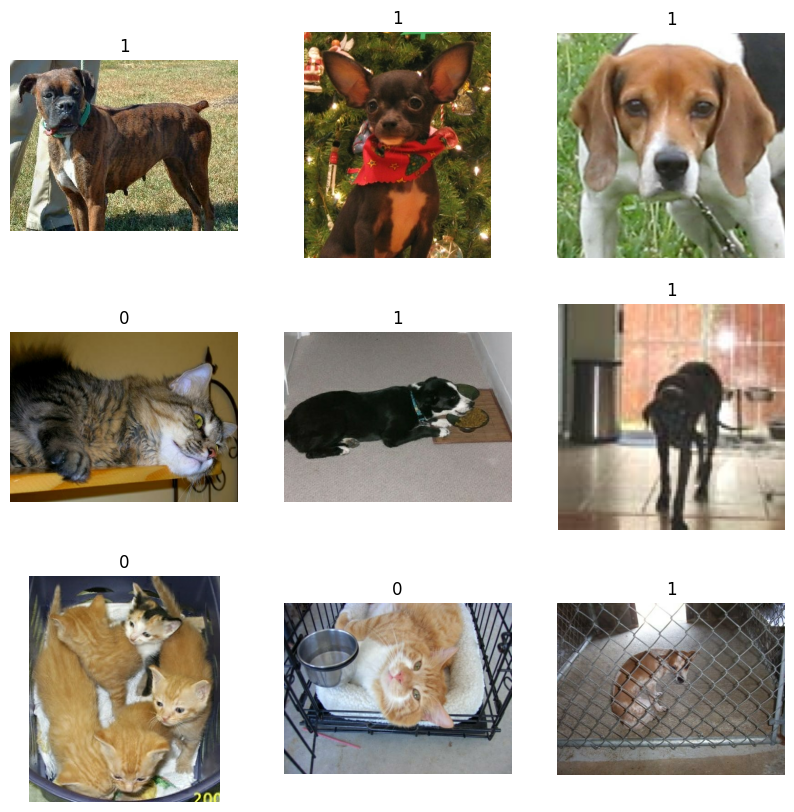

In [13]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

또한, 라벨 1은 "개"이고 라벨 0은 "고양이"인 것을 알 수 있습니다.

### 데이터 표준화

원본 이미지들은 다양한 크기를 가지고 있습니다.
또한, 각 픽셀은 0에서 255 사이의 3개의 정수 값으로 이루어져 있습니다. (RGB 값)
이는 신경망에 적합한 입력 형태가 아닙니다. 우리는 두 가지 작업을 수행해야 합니다:

*   고정된 이미지 크기로 표준화합니다. 150x150을 선택합니다.
*   픽셀 값을 -1에서 1 사이로 정규화합니다. 이를 위해 `Normalization` 레이어를 모델의 일부로 사용할 것입니다.

일반적으로, 이미 전처리된 데이터를 입력으로 사용하는 모델보다는,
원본 데이터를 입력으로 받는 모델을 개발하는 것이 좋습니다.
그 이유는, 모델이 전처리된 데이터를 기대할 경우,
모델을 다른 환경(예: 웹 브라우저, 모바일 앱)에서 사용할 때마다,
동일한 전처리 파이프라인을 다시 구현해야 하기 때문입니다.
이는 매우 까다로워질 수 있습니다.
따라서, 모델에 입력하기 전에 가능한 한 적은 양의 전처리만 수행하는 것이 좋습니다.

여기서는 데이터 파이프라인에서 이미지 크기 조정을 수행할 것입니다.
(딥러닝 신경망은 연속적인 데이터 배치만 처리할 수 있기 때문입니다)
그리고 입력 값 스케일링은 모델을 만들 때 모델의 일부로 수행할 것입니다.

이미지를 150x150 크기로 조정해봅시다:

In [14]:
resize_fn = keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

### 랜덤 데이터 보강 사용

대규모 이미지 데이터셋이 없을 때,
트레이닝 이미지에 랜덤하지만 현실적인 변환을 적용하여,
인위적으로 샘플 다양성을 도입하는 것이 좋습니다.
예를 들어, 랜덤한 가로 뒤집기나 작은 각도의 랜덤 회전을 적용할 수 있습니다.
이렇게 하면 모델이 트레이닝 데이터의 다양한 측면에 노출되면서 과적합을 늦출 수 있습니다.

In [15]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

데이터를 배치로 처리하고, 로딩 속도를 최적화하기 위해 prefetching을 사용해봅시다.

In [16]:
from tensorflow import data as tf_data

batch_size = 64

train_ds = train_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
validation_ds = validation_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
test_ds = test_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()

첫 번째 배치의 첫 번째 이미지가 다양한 랜덤 변환을 거친 후 어떻게 보이는지 시각화해봅시다:

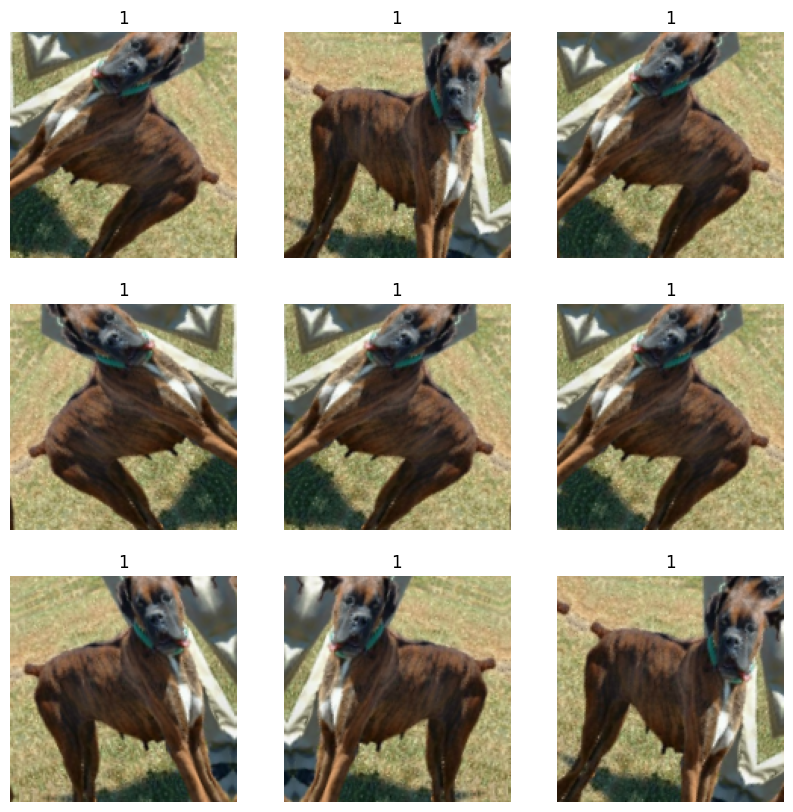

In [17]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

## 모델 빌드

이제 이전에 설명한 설계도를 따르는 모델을 빌드해봅시다.

참고 사항:

*   입력 값을 `[0, 255]` 범위에서 `[-1, 1]` 범위로 스케일링하기 위해, `Rescaling` 레이어를 추가합니다.
*   정규화를 위해, 분류 레이어 앞에 `Dropout` 레이어를 추가합니다.
*   베이스 모델을 호출할 때 `training=False`를 전달하여, 배치 정규화 통계가 업데이트되지 않도록,
    추론 모드에서 실행되도록 해야 합니다.
    미세 조정을 위해 베이스 모델을 동결 해제한 후에도, 이 설정을 유지합니다.

In [18]:
base_model = keras.applications.Xception(
    weights="imagenet",  # ImageNet에서 사전 트레이닝된 가중치 로드.
    input_shape=(150, 150, 3),
    include_top=False,
)  # 상단에 ImageNet 분류기를 포함하지 않음.

# 베이스 모델 동결
base_model.trainable = False

# 상단에 새 모델 생성
inputs = keras.Input(shape=(150, 150, 3))

# 사전 트레이닝된 Xception 가중치는 입력이 (0, 255) 범위에서
# (-1., +1.) 범위로 스케일링되어야 합니다.
# Rescaling 레이어의 출력은: `(inputs * scale) + offset`입니다.
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# 베이스 모델에 배치 정규화 레이어가 포함되어 있습니다.
# 미세 조정을 위해 베이스 모델을 동결 해제할 때도 추론 모드에서 유지되도록
# 베이스 모델이 여기서 추론 모드로 실행되게 합니다.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Dropout과 함께 정규화
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_4 (InputLayer)          │ (None, 150, 150, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ rescaling (Rescaling)               │ (None, 150, 150, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ xception (Functional)               │ (None, 5, 5, 2048)           │    20,861,480 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d            │ (None, 2048)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout (Dropout)                   │ (None, 2048)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_7 (Dense)                     │ (None, 1)                    │         2,049 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

## 상단 레이어 트레이닝

In [19]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 2
print("Fitting the top layer of the model")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Fitting the top layer of the model
Epoch 1/2
146/146 ━━━━━━━━━━━━━━━━━━━━ 28s 162ms/step - binary_accuracy: 0.8458 - loss: 0.3089 - val_binary_accuracy: 0.9652 - val_loss: 0.0887
Epoch 2/2
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - binary_accuracy: 0.9432 - loss: 0.1329 - val_binary_accuracy: 0.9695 - val_loss: 0.0806


## 전체 모델의 미세 조정 단계

마지막으로, 베이스 모델의 동결을 해제하고, 낮은 학습률로 엔드 투 엔드로 전체 모델을 트레이닝합니다.

중요한 점은, 베이스 모델이 트레이닝 가능해지더라도,
모델을 빌드할 때 `training=False`를 전달했기 때문에 여전히 추론 모드로 실행된다는 것입니다.
이는 내부의 배치 정규화 레이어들이 배치 통계를 업데이트하지 않음을 의미합니다.
만약 업데이트된다면, 지금까지 모델이 학습한 표현에 큰 혼란을 일으킬 것입니다.

In [20]:
# 베이스 모델의 동결 해제.
# 모델을 호출할 때 `training=False`를 전달했으므로
# 여전히 추론 모드로 실행됩니다.
# 즉, 배치 정규화 레이어는 배치 통계를
# 업데이트하지 않으며, 이는 지금까지의 트레이닝을 무효화하는 것을 방지합니다.
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # 낮은 학습률
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 1
print("엔드 투 엔드 모델을 피팅 중입니다")
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_4 (InputLayer)          │ (None, 150, 150, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ rescaling (Rescaling)               │ (None, 150, 150, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ xception (Functional)               │ (None, 5, 5, 2048)           │    20,861,480 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ global_average_pooling2d            │ (None, 2048)                 │             0 │    -    │
│ (GlobalAveragePooling2D)            │                              │               │         │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dropout (Dropout)                   │ (None, 2048)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense_7 (Dense)                     │ (None, 1)                    │         2,049 │    Y    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 20,867,629 (79.60 MB)

 Trainable params: 20,809,001 (79.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 4,100 (16.02 KB)

엔드 투 엔드 모델을 피팅 중입니다
146/146 ━━━━━━━━━━━━━━━━━━━━ 40s 189ms/step - binary_accuracy: 0.8585 - loss: 0.3566 - val_binary_accuracy: 0.9613 - val_loss: 0.1033


10 에포크 후, 미세 조정을 통해 성능이 상당히 개선되었습니다. 이제 테스트 데이터셋에서 모델을 평가해봅시다:


In [21]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - binary_accuracy: 0.9597 - loss: 0.0951


[0.10600543022155762, 0.9552880525588989]